$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 5.

To use a custom dataset, edit the `PART5_CUSTOM_DATA_URL` variable in `hw3/answers.py`.(see part 5)

In [2]:
import helpers.plot as plot
import helpers.download
from hw3.answers import PART6_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = helpers.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

Saved to /home/yarivlevy81/.pytorch-datasets/lfw-bush.zip.
Extracting /home/yarivlevy81/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/yarivlevy81/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


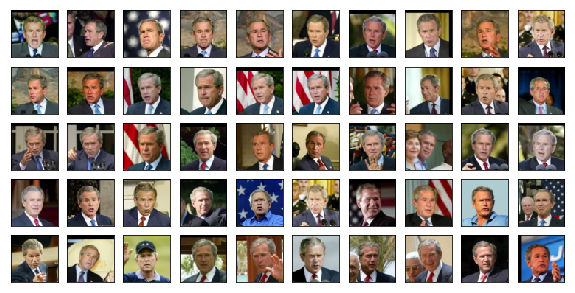

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=16,

**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (seq): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

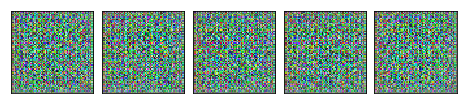

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part6_gan_hyperparam()` function within the `hw3/answers.py` module.

In [12]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part6_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part6_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 64, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002}}


**TODO**:
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training.

--- EPOCH 1/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.53it/s]
Discriminator loss: 0.07785217836499214
Generator loss:     6.029250409868029


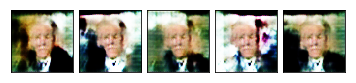

--- EPOCH 2/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.53it/s]
Discriminator loss: 0.05217199441459444
Generator loss:     6.533591588338216


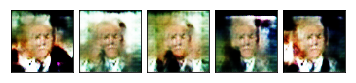

--- EPOCH 3/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.06825038376781675
Generator loss:     5.873811033036974


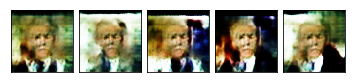

--- EPOCH 4/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.13330377845300567
Generator loss:     6.00226010216607


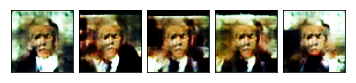

--- EPOCH 5/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.1674583065840933
Generator loss:     5.585058477189806


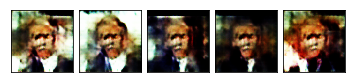

--- EPOCH 6/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.08649291739695603
Generator loss:     6.015186945597331


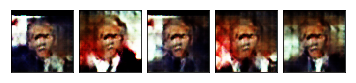

--- EPOCH 7/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.018747777160671022
Generator loss:     6.700778590308295


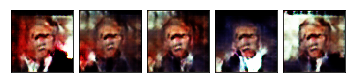

--- EPOCH 8/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.015510187380843692
Generator loss:     7.342183748881022


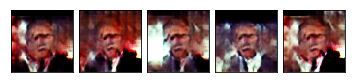

--- EPOCH 9/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.14636717757417095
Generator loss:     6.692081027560764


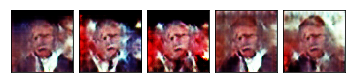

--- EPOCH 10/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.24346563965082169
Generator loss:     5.906689378950331


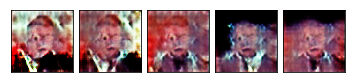

--- EPOCH 11/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.13766075919071832
Generator loss:     5.02290693918864


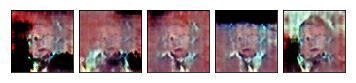

--- EPOCH 12/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.07031272186173333
Generator loss:     6.0722743140326605


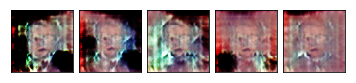

--- EPOCH 13/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.08290516253974703
Generator loss:     6.5186118549770775


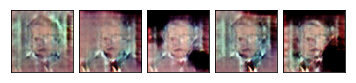

--- EPOCH 14/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.16980033885273668
Generator loss:     6.713200675116645


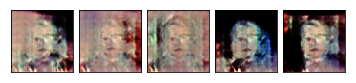

--- EPOCH 15/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.014952305497394668
Generator loss:     7.010718769497341


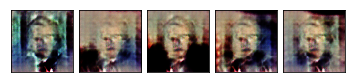

--- EPOCH 16/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.08073089809881316
Generator loss:     6.145645194583469


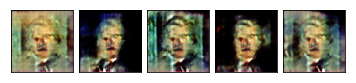

--- EPOCH 17/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.11337803552548091
Generator loss:     6.139629522959392


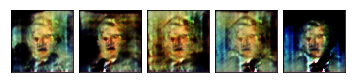

--- EPOCH 18/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: -0.015560650991068946
Generator loss:     6.314914279513889


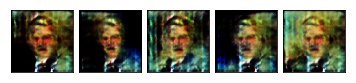

--- EPOCH 19/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.09870401355955336
Generator loss:     7.28298118379381


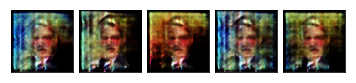

--- EPOCH 20/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.13886317900485462
Generator loss:     8.078827487097847


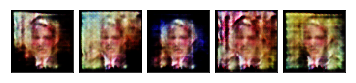

--- EPOCH 21/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.12604532225264442
Generator loss:     9.080635070800781


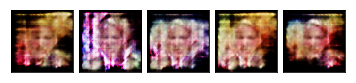

--- EPOCH 22/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.10812230449583796
Generator loss:     7.042820506625706


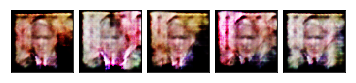

--- EPOCH 23/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: -0.03792972986896833
Generator loss:     7.43231905831231


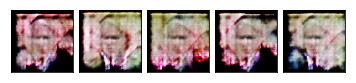

--- EPOCH 24/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.16574286959237522
Generator loss:     7.1744645436604815


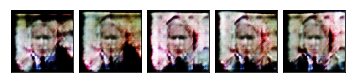

--- EPOCH 25/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.57it/s]
Discriminator loss: 0.05071764522128635
Generator loss:     6.395182026757134


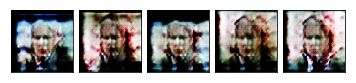

--- EPOCH 26/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.02845796901318762
Generator loss:     6.650118880801731


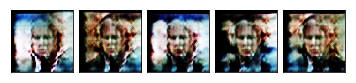

--- EPOCH 27/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.1046397557689084
Generator loss:     6.9878584543863935


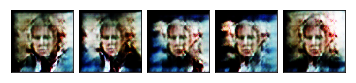

--- EPOCH 28/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: -0.02069400457872285
Generator loss:     7.659036689334446


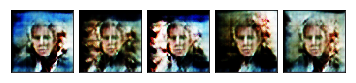

--- EPOCH 29/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.003217079159286287
Generator loss:     7.205762492285834


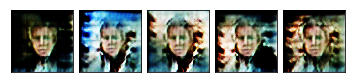

--- EPOCH 30/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.08425555005669594
Generator loss:     7.352152188618978


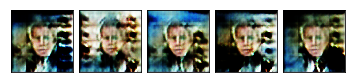

--- EPOCH 31/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.01600401745074325
Generator loss:     6.577053387959798


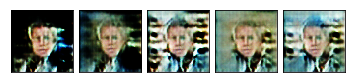

--- EPOCH 32/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.12482394898931186
Generator loss:     6.125401390923394


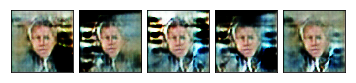

--- EPOCH 33/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.05620488814181752
Generator loss:     6.764485836029053


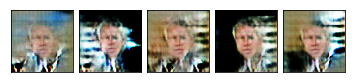

--- EPOCH 34/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.0659093057943715
Generator loss:     7.3587015469868975


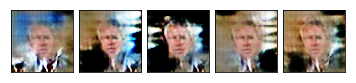

--- EPOCH 35/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.14820210387309393
Generator loss:     7.540960788726807


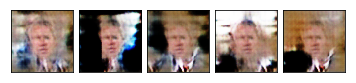

--- EPOCH 36/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.062473713523811765
Generator loss:     6.859216584099664


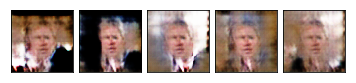

--- EPOCH 37/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.05926986307733589
Generator loss:     7.078822241889106


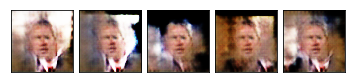

--- EPOCH 38/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.038040195488267474
Generator loss:     6.543327649434407


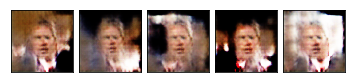

--- EPOCH 39/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.12912648171186447
Generator loss:     6.543933179643419


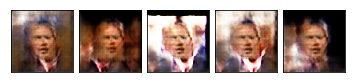

--- EPOCH 40/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.53it/s]
Discriminator loss: 0.12705615907907486
Generator loss:     6.8344921535915795


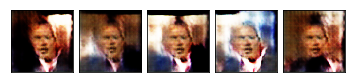

--- EPOCH 41/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.024416914623644616
Generator loss:     6.683141920301649


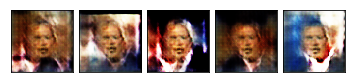

--- EPOCH 42/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.09715003271897633
Generator loss:     6.121359295315212


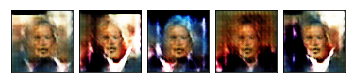

--- EPOCH 43/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.05674893864327007
Generator loss:     6.203716648949517


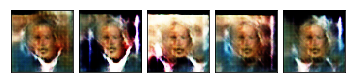

--- EPOCH 44/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.08394362404942513
Generator loss:     6.578926828172472


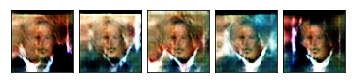

--- EPOCH 45/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.12904901512795025
Generator loss:     6.130856884850396


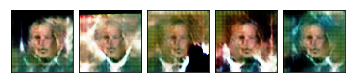

--- EPOCH 46/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.18892134560479057
Generator loss:     6.327010207706028


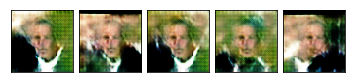

--- EPOCH 47/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.1391238071438339
Generator loss:     6.0378749635484485


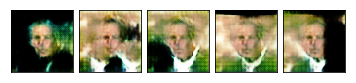

--- EPOCH 48/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.022630962646669812
Generator loss:     6.8781758944193525


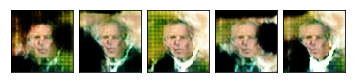

--- EPOCH 49/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.05827420329054197
Generator loss:     7.091402742597792


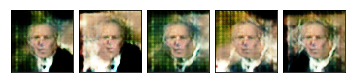

--- EPOCH 50/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.09836907912459639
Generator loss:     6.06167729695638


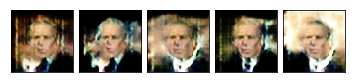

--- EPOCH 51/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.09193480635682742
Generator loss:     6.1614813804626465


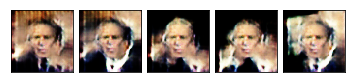

--- EPOCH 52/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.049691504074467555
Generator loss:     6.580877463022868


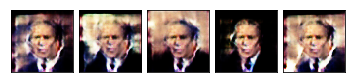

--- EPOCH 53/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.1616887061132325
Generator loss:     5.981108294592963


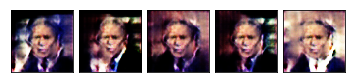

--- EPOCH 54/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.15047755506303576
Generator loss:     6.201760768890381


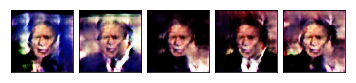

--- EPOCH 55/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.53it/s]
Discriminator loss: 0.044120323947734304
Generator loss:     6.148355378044976


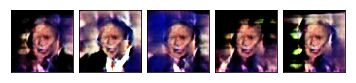

--- EPOCH 56/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.06148624492602216
Generator loss:     7.244377983940972


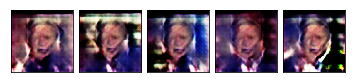

--- EPOCH 57/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.09273992644415961
Generator loss:     6.939986069997151


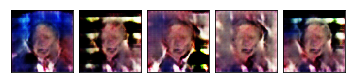

--- EPOCH 58/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.57it/s]
Discriminator loss: 0.12865531858470705
Generator loss:     6.561787499321832


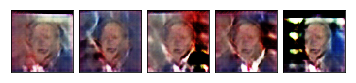

--- EPOCH 59/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.150676638715797
Generator loss:     6.083439350128174


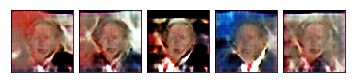

--- EPOCH 60/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.60it/s]
Discriminator loss: 0.09065298818879658
Generator loss:     6.257842593722874


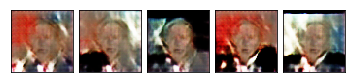

--- EPOCH 61/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.1096920586294598
Generator loss:     6.66148567199707


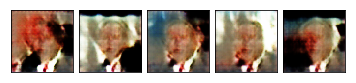

--- EPOCH 62/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.1082281797296471
Generator loss:     6.743739816877577


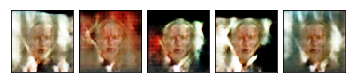

--- EPOCH 63/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.11461097954048051
Generator loss:     6.457735644446479


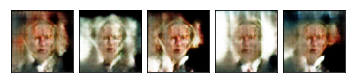

--- EPOCH 64/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.103590394059817
Generator loss:     6.798710293240017


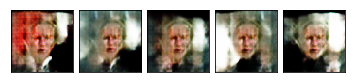

--- EPOCH 65/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: -0.06189719898005327
Generator loss:     7.913516945309109


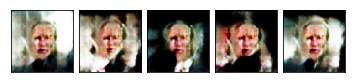

--- EPOCH 66/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: -0.07614603266119957
Generator loss:     7.8592681884765625


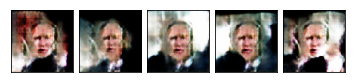

--- EPOCH 67/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.06576303392648697
Generator loss:     8.616259892781576


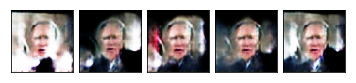

--- EPOCH 68/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.25100843028889763
Generator loss:     7.643079386817084


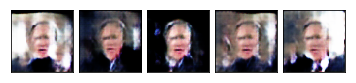

--- EPOCH 69/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.015282033218277825
Generator loss:     7.089525752597385


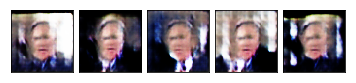

--- EPOCH 70/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.02813936521609624
Generator loss:     6.323122130499946


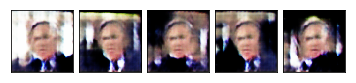

--- EPOCH 71/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: -0.009167191055085924
Generator loss:     7.555740144517687


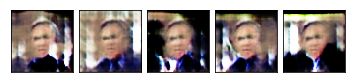

--- EPOCH 72/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.17287921657164892
Generator loss:     7.7618087662590876


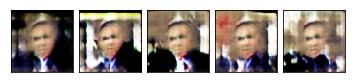

--- EPOCH 73/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.11933203414082527
Generator loss:     6.4686611493428545


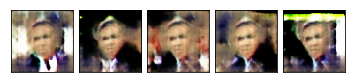

--- EPOCH 74/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.05956543402539359
Generator loss:     5.707481437259251


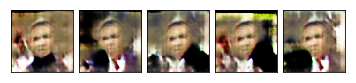

--- EPOCH 75/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.006080511750446426
Generator loss:     7.042629665798611


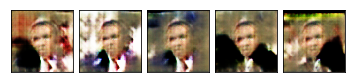

--- EPOCH 76/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.05614642302195231
Generator loss:     6.7421806653340655


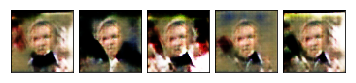

--- EPOCH 77/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.014774432198868858
Generator loss:     7.386575910780165


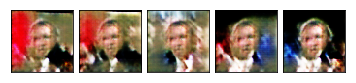

--- EPOCH 78/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.15253998877273667
Generator loss:     6.989030361175537


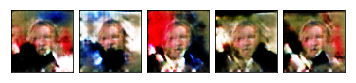

--- EPOCH 79/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.04295793320569727
Generator loss:     6.431895732879639


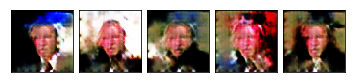

--- EPOCH 80/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.10482344672911698
Generator loss:     7.421966552734375


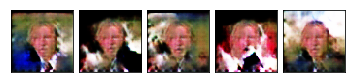

--- EPOCH 81/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.53it/s]
Discriminator loss: 0.09644909906718466
Generator loss:     6.63229587343004


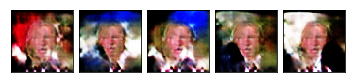

--- EPOCH 82/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.0412548900478416
Generator loss:     6.741213692559136


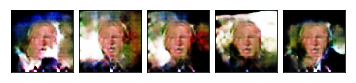

--- EPOCH 83/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.53it/s]
Discriminator loss: 0.12341683109601338
Generator loss:     6.916180875566271


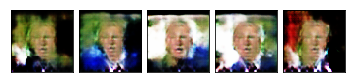

--- EPOCH 84/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.08962248472703828
Generator loss:     6.076949543423122


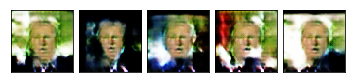

--- EPOCH 85/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.004232863171233071
Generator loss:     6.676481935713026


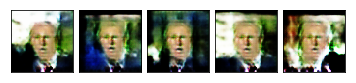

--- EPOCH 86/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.035072244703769684
Generator loss:     7.470896402994792


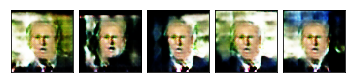

--- EPOCH 87/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.016588484247525532
Generator loss:     7.694575468699138


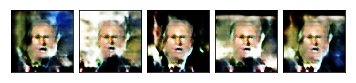

--- EPOCH 88/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.09279241454270151
Generator loss:     6.815144432915582


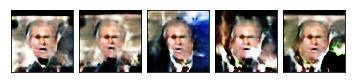

--- EPOCH 89/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.05424260058336788
Generator loss:     5.8366522789001465


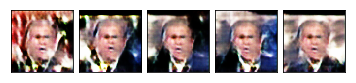

--- EPOCH 90/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.20612484216690063
Generator loss:     6.816014925638835


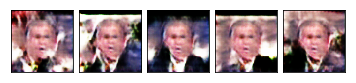

--- EPOCH 91/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.12904265854093763
Generator loss:     7.865159034729004


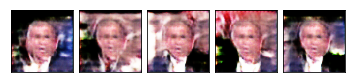

--- EPOCH 92/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.14219647149244943
Generator loss:     6.320395257737902


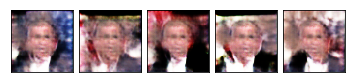

--- EPOCH 93/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.1403883799082703
Generator loss:     5.796165042453342


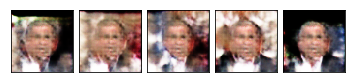

--- EPOCH 94/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.15674427193072107
Generator loss:     6.417943689558241


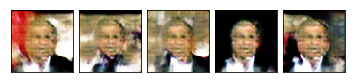

--- EPOCH 95/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.56it/s]
Discriminator loss: 0.10170376714732912
Generator loss:     6.134104251861572


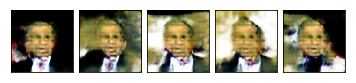

--- EPOCH 96/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.09862455353140831
Generator loss:     6.373028225368923


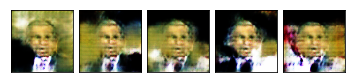

--- EPOCH 97/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.53it/s]
Discriminator loss: 0.11973873650034268
Generator loss:     7.495922565460205


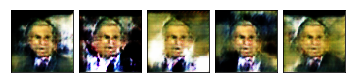

--- EPOCH 98/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.19788611431916556
Generator loss:     6.261011547512478


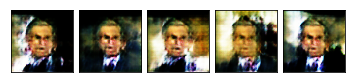

--- EPOCH 99/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.55it/s]
Discriminator loss: 0.22708902570108572
Generator loss:     7.095085250006782


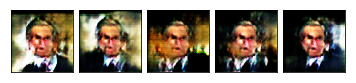

--- EPOCH 100/100 ---
100%|██████████| 9/9 [00:06<00:00,  1.54it/s]
Discriminator loss: 0.13167585598097908
Generator loss:     6.0970099502139625


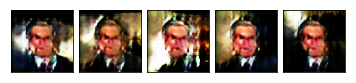

In [21]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


*** Images Generated from best model:


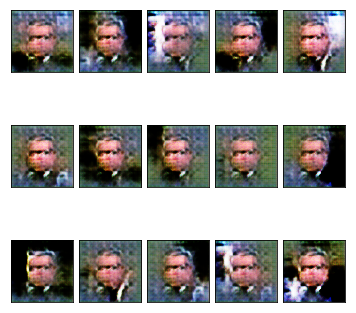

In [19]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [1]:
from helpers.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [2]:
display_answer(hw3.answers.part6_q1)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [3]:
display_answer(hw3.answers.part6_q2)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [4]:
display_answer(hw3.answers.part6_q3)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

